In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [2]:
# Step 1: Define paths and parameters
data_dir = r'd:\Users\HomePC\Downloads\merged_dataset' # Replace with the path to your dataset
categories = ['iron','copper','aluminium','others']
img_size = (128, 128)
batch_size = 32

# Step 2: Data Augmentation and Preprocessing
data_gen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest',
    validation_split=0.2  # 20% data for validation
)

train_data = data_gen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = data_gen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Step 2.1: Compute Class Weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weights = dict(enumerate(class_weights))


Found 1623 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


In [3]:
# Step 3: Build the Model using Transfer Learning
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Freeze base layers

# Freeze earlier layers, fine-tune only the last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(3, activation='softmax')
])

# Step 4: Compile the Model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,  # Lower learning rate for fine-tuning
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\HomePC\anaconda3\envs\scrapenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.3370 - loss: 3.8397 - val_accuracy: 0.3580 - val_loss: 3.4076
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3238 - loss: 3.5756 - val_accuracy: 0.3630 - val_loss: 3.3269
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3511 - loss: 3.4583 - val_accuracy: 0.5160 - val_loss: 3.1666
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3928 - loss: 3.3344 - val_accuracy: 0.5111 - val_loss: 3.1557
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4107 - loss: 3.1817 - val_accuracy: 0.4519 - val_loss: 3.2148
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3935 - loss: 3.1438 - val_accuracy: 0.4617 - val_loss: 3.1060
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4122 - loss: 3.1431 - val_accuracy: 0.4667 - val_loss: 3.0755
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4622 - loss: 3.0018 - val_accuracy: 0.5012 - val_loss:

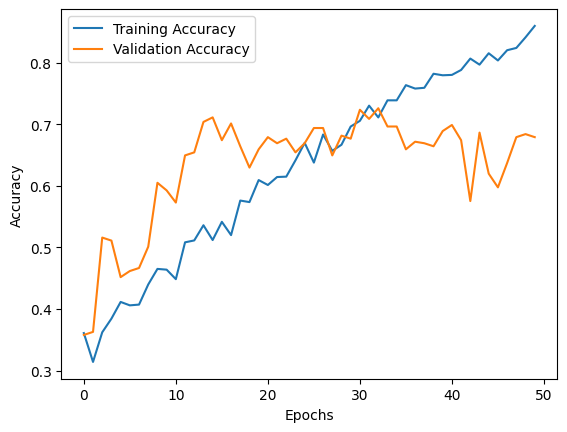

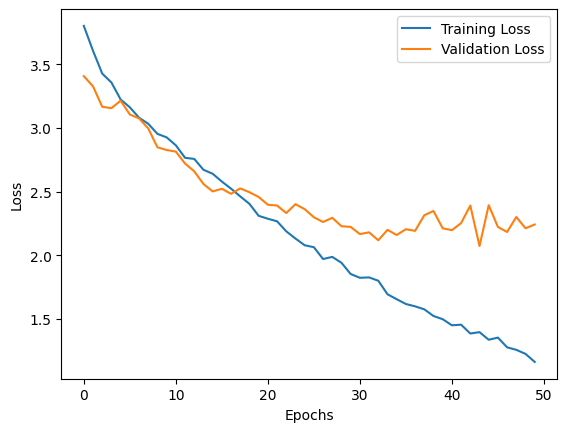

In [4]:
# Step 5: Train the Model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping],
    class_weight=class_weights  # Apply class weights
)


# Step 6: Save the Model
model.save(r'd:\Users\HomePC\Desktop\waste_management.h5')

# Step 7: Evaluate the Model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#the below is the warning to call kwargs. without that call the code still executes

In [5]:
# Step 8: Test the Model (Optional)
def predict_image(image_path):
    from tensorflow.keras.utils import load_img, img_to_array
    import numpy as np

    img = load_img(image_path, target_size=img_size)  # Load image with specified size
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = tf.expand_dims(img_array, 0)  # Expand dimensions to match model input
    
    predictions = model.predict(img_array)  # Get predictions
    class_idx = tf.argmax(predictions[0]).numpy()  # Get class index
    class_label = categories[class_idx]  # Map to class label
    return class_label

# Test with a sample image
sample_image_path = r"d:\Users\HomePC\Downloads\merged_dataset\test\images\garbage_classification.v1i.yolov11_000019_JPG.rf.6f3313fccc0d127e8793245360c4362b.jpg"  # Replace with an actual image path
print("Predicted Class:", predict_image(sample_image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: iron


Processing sample image: d:\Users\HomePC\Downloads\merged_dataset\test\images\garbage_classification.v1i.yolov11_000007_jpg.rf.4d098d8b7d2c82b1f5ff3db96181d5a0.jpg


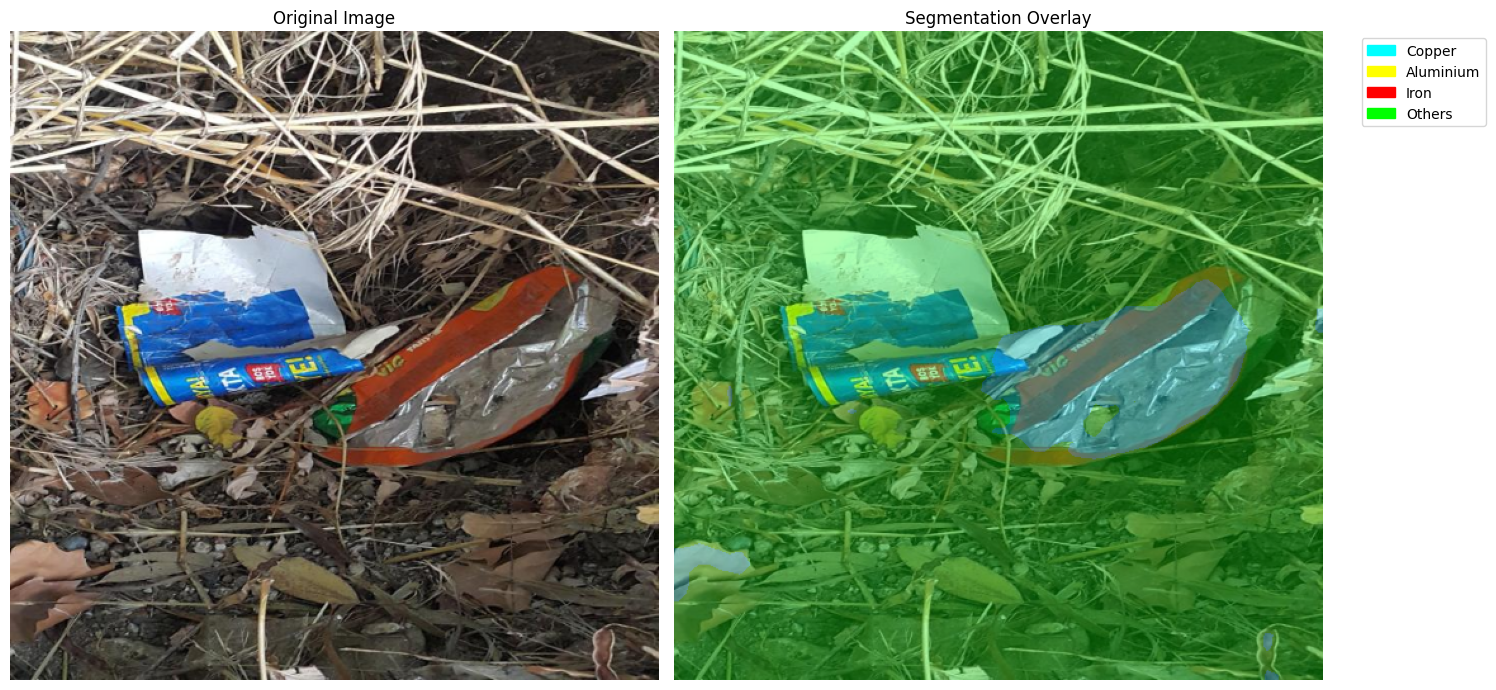


===== Evaluation Results (181 images) =====
Overall Accuracy: 0.2495
Mean Pixel Accuracy: 0.2495
Mean IoU: 0.0790

===== Per-Class Metrics =====
Copper:
  IoU: 0.0224
  Accuracy: 0.0427
Aluminium:
  IoU: 0.0358
  Accuracy: 0.0763
Iron:
  IoU: 0.0341
  Accuracy: 0.0835
Others:
  IoU: 0.2236
  Accuracy: 0.7953

===== Classification Report =====
              precision    recall  f1-score   support

      Copper       0.20      0.04      0.07  11862016
   Aluminium       0.27      0.08      0.12  11862016
        Iron       0.24      0.08      0.12  11862016
      Others       0.25      0.80      0.38  11862016

    accuracy                           0.25  47448064
   macro avg       0.24      0.25      0.17  47448064
weighted avg       0.24      0.25      0.17  47448064


===== Confusion Matrix =====
[[ 507026  960190 1119389 9275411]
 [ 629363  904710 1062307 9265636]
 [ 724061  805957  990560 9341438]
 [ 707987  691537 1028111 9434381]]


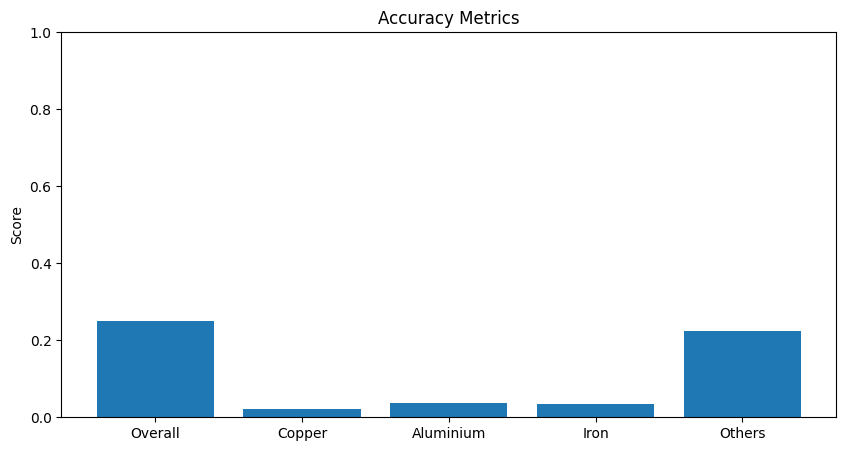

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ===== Configuration =====
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 4  # Copper, Aluminium, Iron, Others
CLASS_NAMES = ['Copper', 'Aluminium', 'Iron', 'Others']

# ===== Model Definition =====
def get_deeplabv3_model(num_classes=4):
    """Initialize and modify DeepLabV3 model for custom classes"""
    model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
    # Modify the final classifier layer
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model.to(DEVICE)

# ===== Image Preprocessing =====
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# ===== Inference Function =====
def segment_image(model, image_path, visualize=True):
    """Perform segmentation on a single image"""
    model.eval()
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError(f"Image not found or unreadable at {image_path}")
    
    image = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (512, 512))
    input_tensor = transform(image_resized).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)['out']
        mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    if visualize:
        # Create color mapping for visualization
        colors = np.array([
            [0, 255, 255],    # Copper - Cyan
            [255, 255, 0],    # Aluminium - Yellow
            [255, 0, 0],      # Iron - Blue
            [0, 255, 0]       # Others - Green
        ], dtype=np.uint8)
        
        colored_mask = colors[mask]
        overlay = cv2.addWeighted(image_resized, 0.7, colored_mask, 0.3, 0)
        
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(image_resized)
        plt.title("Original Image")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(overlay)
        plt.title("Segmentation Overlay")
        plt.axis("off")
        
        # Add legend
        handles = [plt.Rectangle((0,0),1,1, color=color/255) for color in colors]
        plt.legend(handles, CLASS_NAMES, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    return mask

# ===== Evaluation Metrics =====
def calculate_iou(true_mask, pred_mask, class_id):
    """Calculate Intersection over Union for a specific class"""
    intersection = np.logical_and(true_mask == class_id, pred_mask == class_id)
    union = np.logical_or(true_mask == class_id, pred_mask == class_id)
    return np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0

def calculate_pixel_accuracy(true_mask, pred_mask):
    """Calculate overall pixel accuracy"""
    return np.sum(true_mask == pred_mask) / true_mask.size

# ===== Enhanced Evaluation Function =====
def evaluate_model(model, test_dir):
    """Evaluate model performance on test directory"""
    all_preds = []
    all_true = []
    class_ious = {i: [] for i in range(NUM_CLASSES)}
    pixel_accuracies = []
    processed_files = 0
    
    for file in os.listdir(test_dir):
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            path = os.path.join(test_dir, file)
            try:
                # Get prediction
                pred_mask = segment_image(model, path, visualize=False)
                
                # Create simulated ground truth (replace with actual masks in real usage)
                height, width = pred_mask.shape
                gt_mask = np.zeros_like(pred_mask)
                gt_mask[:height//4] = 0  # Copper
                gt_mask[height//4:height//2] = 1  # Aluminium
                gt_mask[height//2:3*height//4] = 2  # Iron
                gt_mask[3*height//4:] = 3  # Others
                
                # Store for overall metrics
                all_preds.extend(pred_mask.flatten())
                all_true.extend(gt_mask.flatten())
                
                # Calculate pixel accuracy for this image
                pixel_accuracies.append(calculate_pixel_accuracy(gt_mask, pred_mask))
                
                # Calculate IoU for each class
                for class_id in range(NUM_CLASSES):
                    iou = calculate_iou(gt_mask, pred_mask, class_id)
                    class_ious[class_id].append(iou)
                
                processed_files += 1
            except Exception as e:
                print(f"Error processing {file}: {str(e)}")
    
    if not all_preds:
        print("No valid predictions were made.")
        return
    
    # Calculate overall metrics
    overall_accuracy = accuracy_score(all_true, all_preds)
    mean_pixel_accuracy = np.mean(pixel_accuracies)
    mean_ious = [np.mean(class_ious[i]) for i in range(NUM_CLASSES)]
    mean_iou = np.mean(mean_ious)
    
    print(f"\n===== Evaluation Results ({processed_files} images) =====")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    
    # Per-class metrics
    print("\n===== Per-Class Metrics =====")
    for i in range(NUM_CLASSES):
        print(f"{CLASS_NAMES[i]}:")
        print(f"  IoU: {mean_ious[i]:.4f}")
        print(f"  Accuracy: {np.sum([(t==i and p==i) for t,p in zip(all_true, all_preds)])/max(1, np.sum([t==i for t in all_true])):.4f}")
    
    # Classification report
    print("\n===== Classification Report =====")
    print(classification_report(
        all_true, 
        all_preds, 
        target_names=CLASS_NAMES,
        zero_division=0
    ))
    
    # Confusion matrix
    print("\n===== Confusion Matrix =====")
    print(confusion_matrix(all_true, all_preds))
    
    return {
        'overall_accuracy': overall_accuracy,
        'mean_pixel_accuracy': mean_pixel_accuracy,
        'mean_iou': mean_iou,
        'class_ious': mean_ious
    }

# ===== Main Execution =====
if __name__ == "__main__":
    # Initialize model
    model = get_deeplabv3_model(num_classes=NUM_CLASSES)
    
    # Test single image
    test_image_path = r"d:\Users\HomePC\Downloads\merged_dataset\test\images\garbage_classification.v1i.yolov11_000007_jpg.rf.4d098d8b7d2c82b1f5ff3db96181d5a0.jpg"
    if os.path.exists(test_image_path):
        print(f"Processing sample image: {test_image_path}")
        sample_mask = segment_image(model, test_image_path, visualize=True)
    else:
        print(f"Sample image not found at {test_image_path}")
        # Try to find any image in the test directory
        test_dir = os.path.join(r"d:\Users\HomePC\Downloads\merged_dataset", "test", "images")
        if os.path.exists(test_dir):
            for file in os.listdir(test_dir):
                if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    test_image_path = os.path.join(test_dir, file)
                    print(f"Processing first found image: {test_image_path}")
                    sample_mask = segment_image(model, test_image_path, visualize=True)
                    break
    
    # Evaluate on test directory
    test_image_dir = os.path.join(r"d:\Users\HomePC\Downloads\merged_dataset", "test", "images")
    if os.path.exists(test_image_dir):
        metrics = evaluate_model(model, test_image_dir)
        
        # Visualize metrics
        plt.figure(figsize=(10, 5))
        plt.bar(['Overall'] + CLASS_NAMES, 
                [metrics['overall_accuracy']] + metrics['class_ious'])
        plt.title('Accuracy Metrics')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.show()
    else:
        print(f"Test directory not found at {test_image_dir}")